## Desktop Image Classification

*This notebook is largely based on [this tutorial](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson2-download.ipynb) from [fast.ai](https://www.fast.ai/)*



In [2]:
from fastai.vision import *

In [3]:
path = Path('data/desktop')

In [4]:
path.ls()

[PosixPath('data/desktop/music'),
 PosixPath('data/desktop/.ipynb_checkpoints'),
 PosixPath('data/desktop/info')]

In [5]:
classes = ['music','info']

*Next, I place the* **images** *into the* **directory**

**Loading the images as data**

In [7]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=2,bs=16).normalize(imagenet_stats)

In [8]:
data.classes

['info', 'music']

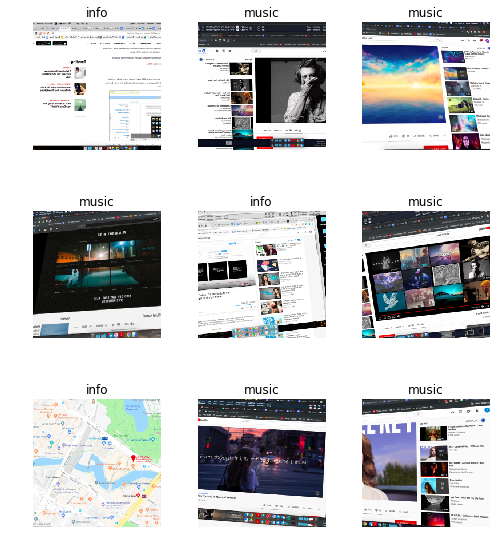

In [9]:
data.show_batch(rows=3, figsize=(7,8))
#weird that it's made a lot of the screenshots stretched diagonally after regularation


In [10]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)


(['info', 'music'], 2, 53, 13)

**Train Model**

In [17]:
model = cnn_learner(data, models.resnet34, metrics=error_rate)

In [18]:
model.save('model-1')

In [19]:
model.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.674362,0.662550,0.307692,00:04
1,1.229562,0.233696,0.076923,00:04
2,0.961871,0.157272,0.076923,00:04
3,0.780608,0.139398,0.076923,00:04


In [20]:
model.save('model-2')

*The model does pretty well by the last epoch but appears to be learning a bit slow, so we'll play with the lr*

In [22]:
model.load('model-1');

In [23]:
model.fit_one_cycle(3, max_lr=slice(1e-3,1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,1.431887,0.553133,0.153846,00:04
1,0.913439,0.475510,0.153846,00:04
2,0.710783,0.200320,0.076923,00:04


In [24]:
model.save('model-3')

In [25]:
model.unfreeze()

In [30]:
model.lr_find(1e-5,1e-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


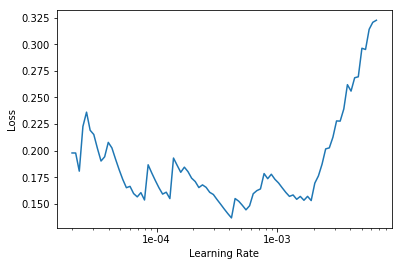

In [31]:
model.recorder.plot()

In [35]:
model.fit_one_cycle(6, max_lr=slice(3e-4,1e-3))


epoch,train_loss,valid_loss,error_rate,time
0,0.155550,0.084222,0.076923,00:04
1,0.075571,0.000005,0.000000,00:04
2,0.057508,0.000350,0.000000,00:04
3,0.049959,0.017534,0.000000,00:04
4,0.052507,0.047740,0.000000,00:04
5,0.054483,0.015635,0.000000,00:04


In [36]:
model.save('model-4')

This is really weird. Model 4 appears to have an error rate of 0. I suppose this is possible and likely given the small data set, but probably indicates over-fitting. 
**Let's load model 3, which had an error rate of 0.07 and see what the results indicate.**

In [37]:
model.load('model-3');

In [38]:
interp = ClassificationInterpretation.from_learner(model)

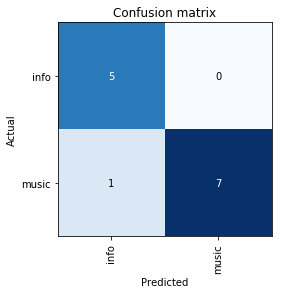

In [39]:
interp.plot_confusion_matrix()

*It appears that our model does pretty well*

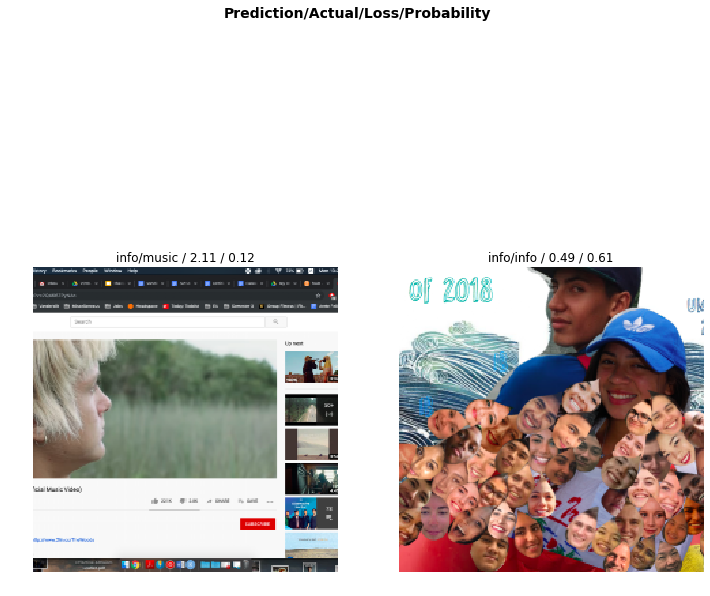

In [41]:
interp.plot_top_losses(k=2)

### Let's put it into use 
We are going to export 2 models... model 3 with error 0.07 but less overfit and model 4 with error 0 but likely to be overfit. 

In [42]:
model.export()

In [44]:
model.load('model-4');
model.export('perfect_model')

In [45]:
learn = load_learner(path,'export.pkl')

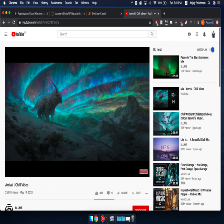

In [46]:
img = open_image(path/'test_1.png')
img = img.resize(224)
img

In [47]:
pred_class,pred_idx,outputs = learn.predict(img)
print(data.classes[np.argmax(outputs)]) #predicts it as music

music


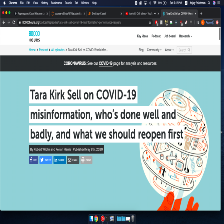

In [48]:
img2 = open_image(path/'test_2.png')
img2 = img2.resize(224)
img2

In [49]:
pred_class,pred_idx,outputs = learn.predict(img2)
print(data.classes[np.argmax(outputs)]) 

info


**Sweet... it looks like both of these images were classified correctly... pretty cool! Let's test our perfect model now.**

In [50]:
learn_2 = load_learner(path,'perfect_model.pkl')

In [51]:
pred_class,pred_idx,outputs = learn_2.predict(img)
print(data.classes[np.argmax(outputs)]) 

music


In [52]:
pred_class,pred_idx,outputs = learn_2.predict(img2)
print(data.classes[np.argmax(outputs)]) 

info


**This one also worked for both. It is a small sample size though. Let's proceed anyways with making an internet application out of it. As my desktop clutters, we'll get more data and will re-train.**